### We study the Michaelis Menten Enzyme kinetics system with 4 species as defined by:

$$
\begin{split}
S + E &\rightleftharpoons^{k_f}_{k_b} C \hspace{20pt} \text{Binding and unbinding of substrate S and enzyme E}\\
C &\rightarrow^{k_d} E + X \hspace{20pt} \text{Production of the product X by the complex C, \textit{typically fast}} \\ 
X &\rightarrow^{k_{2X}} \emptyset \\
S & \leftrightharpoons_{k_{2S}}^{k_{1S}} \emptyset
\end{split}
$$

In [1]:
push!(LOAD_PATH, "../src/Achedmy/")
using Achedmy
using Pkg
using PyPlot
using Catalyst
using LinearAlgebra
using DifferentialEquations
using LaTeXStrings
using Serialization

In [17]:
enzyme_system = @reaction_network begin
    @species S(t) = 1. E(t) = 0.9 C(t) = 0.1 X(t) = 0.1
    @parameters k_f = 1. k_b = 0.1 k_d = 1. k_2X = 1. k_2S = 1. k_1S = 1.
   (k_f,k_b), S + E <--> C
   (k_d), C --> E + X
   (k_2X), X --> 0
   (k_2S,k_1S), S <--> 0
end

Model ##ReactionSystem#236
States (4):
  S(t) [defaults to 1.0]
  E(t) [defaults to 0.9]
  C(t) [defaults to 0.1]
  X(t) [defaults to 0.1]
Parameters (6):
  k_f [defaults to 1.0]
  k_b [defaults to 0.1]
  k_d [defaults to 1.0]
  k_2X [defaults to 1.0]
⋮

In [ ]:
#Parameters simulation
tstart= 0.
tmax = 10.
atol = 1e-3
rtol = 1e-2

0.01

In [20]:
alpha_range = [0.01,0.1,1.,10.]

4-element Vector{Float64}:
  0.01
  0.1
  1.0
 10.0

In [16]:
@unpack k_f = enzyme_system

SOL = []
VAR = []

for i in alpha_range

    enzyme_system.defaults[k_f] = i

    structure = Achedmy.ReactionStructure(enzyme_system)
    variables = Achedmy.ReactionVariables(structure,"cross")
    sol = Achedmy.solve_dynamics!(structure,variables,selfEnergy = "gSBR", tmax = tmax, tstart = tstart,
                     atol = atol, rtol = rtol)

    push!(SOL,sol)
    push!(VAR,variables)

    println("Done for alpha = $i")
end

t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 2.41037276182553e-5
t: 5.1493435537346114e-5
t: 0.00015367096847581401
t: 0.00047473051172433275
t: 0.0012635109899441174
t: 0.002571688656392304
t: 0.005454102439105086
t: 0.009854494406074922
t: 0.01746204050231695
t: 0.02799579612034367
t: 0.0436659997402134
t: 0.06401550373341941
t: 0.0912526744811541
t: 0.1250819328956169
t: 0.16713731063494322
t: 0.21770832169197782
t: 0.27735864621626494
t: 0.34732872205799026
t: 0.4267507200530159
t: 0.512646569707732
t: 0.6073527391505236
t: 0.7106874005492203
t: 0.8224734082315568
t: 0.9430555798259255
t: 1.0724266995364002
t: 1.2105707597266606
t: 1.3574862053980286
t: 1.513099052485861
t: 1.677306609086315
t: 1.8499795935517334
t: 2.0309572788245105
t: 2.220055871453103
t: 2.4170720816830853
t: 2.6217863606328904
t: 2.8339672662946986
t: 3.053375091100818
t: 3.27976521898765
t: 3.51289126482583
t: 3.7525077929205475
t: 3.9983726553965204
t: 4.2502489572188535
t: 4.507906644795408
t: 4.771123745946

In [ ]:
# # Reading data

# SOL = open("../data/enzyme/sol_gSBR.jls", "r") do f
#     deserialize(f)
# end

# VAR = open("../data/enzyme/var_gSBR.jls", "r") do f
#     deserialize(f)
# end

In [25]:
# ## Saving data

# open("../data/enzyme/sol_gSBR.jls", "w") do f
#     serialize(f, SOL)
# end
# open("../data/enzyme/var_gSBR.jls", "w") do f
#     serialize(f, VAR)
# end

### Plot the means:

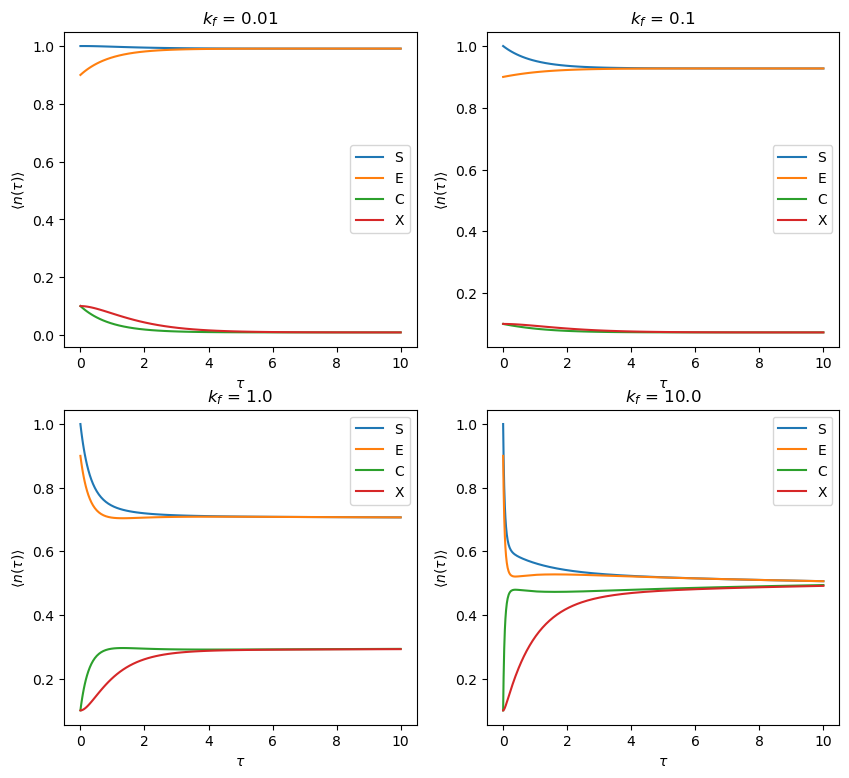

In [18]:
plot_indices = [1,2,3,4]

figure(figsize=(10,9))
for i in range(1,length(plot_indices))
    subplot(2,2,i)
    for j in range(1,length(species(enzyme_system)))
        plot(SOL[plot_indices[i]].t,VAR[plot_indices[i]].μ[j,:],label=alpha_range[plot_indices[i]])
        legend(["S","E","C","X"])
    end
    title(L"$k_f$ = " * string(alpha_range[plot_indices[i]]))
    #yscale("log")
    xlabel(L"$\tau$")
    ylabel(L"$\langle n(\tau)\rangle$")
end

gcf()

In [ ]:
savefig("../plots/enzyme/enzyme_means.png")
close("all")

### Plot the variances:

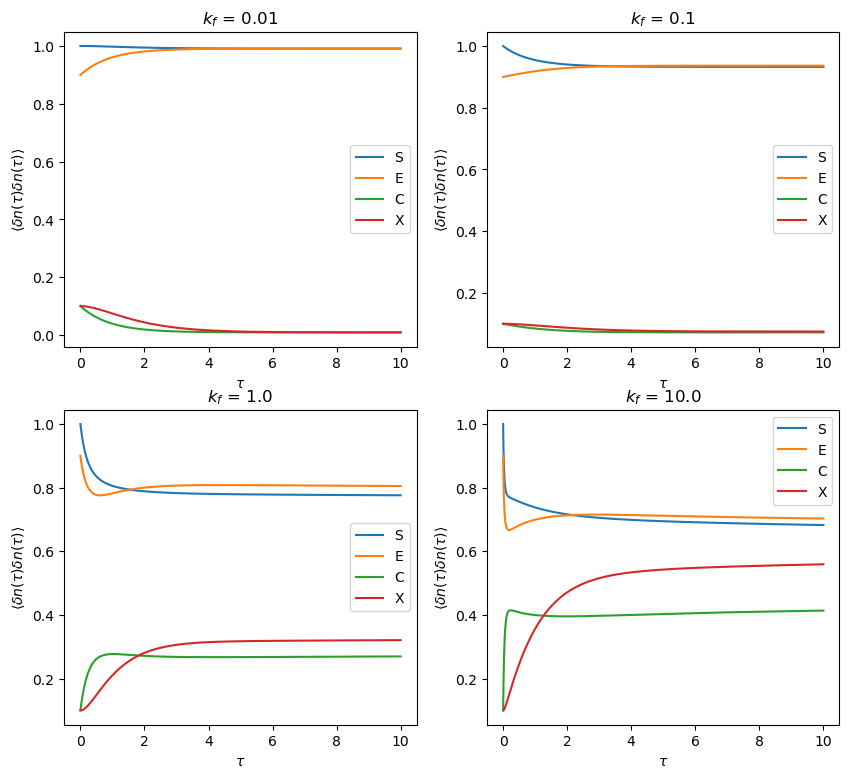

In [33]:
plot_indices = [1,2,3,4]
figure(figsize=(10,9))
for i in range(1,length(plot_indices))
    subplot(2,2,i)
    for j in range(1,length(species(enzyme_system)))
        plot(SOL[plot_indices[i]].t, diag(VAR[plot_indices[i]].N[j,j,:,:]), label=alpha_range[plot_indices[i]])
        legend(["S","E","C","X"])
    end
    title(L"$k_f$ = " * string(alpha_range[plot_indices[i]]))
    #yscale("log")
    xlabel(L"$\tau$")
    ylabel(L"$\langle \delta n(\tau) \delta n(\tau) \rangle$")
end

gcf()

In [21]:
## Running MAK:
@unpack k_f = enzyme_system

SOL_mak = []
VAR_mak = []

for i in alpha_range

    enzyme_system.defaults[k_f] = i
    
    # println(enzyme_system.defaults)
    structure = Achedmy.ReactionStructure(enzyme_system)
    variables = Achedmy.ReactionVariables(structure,"single")
    sol = Achedmy.solve_dynamics!(structure,variables,selfEnergy = "MAK", tmax = tmax, tstart = tstart,
    atol = atol, rtol = rtol)

    push!(SOL_mak,sol)
    push!(VAR_mak,variables)

end


t: 0.0
t: 1.0e-6
t: 5.999999999999999e-6
t: 3.0999999999999995e-5
t: 7.742923593170674e-5
t: 0.00026136336047410003
t: 0.000968233800341838
t: 0.0029285624135270863
t: 0.006336953252600742
t: 0.014819233253419894
t: 0.028332137540383377
t: 0.05347318013536123
t: 0.08874096937926523
t: 0.14362162371943007
t: 0.21380908942346982
t: 0.309847763004556
t: 0.42433077970778404
t: 0.5673241509385943
t: 0.7200841236366775
t: 0.889954043380351
t: 1.0778491771413912
t: 1.2794319281557918
t: 1.4953574944402703
t: 1.72487478914769
t: 1.966418951871268
t: 2.2193486621314777
t: 2.4828106862945485
t: 2.755886788717682
t: 3.0378761820780764
t: 3.328102731686684
t: 3.6259395692424867
t: 3.930849701553485
t: 4.242349642645953
t: 4.560008522494346
t: 4.883449527372507
t: 5.212339359493592
t: 5.546383735497788
t: 5.885323663235662
t: 6.228930238428656
t: 6.577000803608153
t: 6.929355622837784
t: 7.2858346769873386
t: 7.646294993468739
t: 8.01060834459885
t: 8.378659215974883
t: 8.750343078076664
t: 9.12556

In [ ]:
# SOL_mak = open("../data/enzyme/sol_mak.jls", "r") do f
#     deserialize(f)
# end

# VAR_mak = open("../data/enzyme/var_mak.jls", "r") do f
#     deserialize(f)
# end

In [27]:
# open("../data/enzyme/sol_mak.jls", "w") do f
#     serialize(f, SOL_mak)
# end

# open("../data/enzyme/var_mak.jls", "w") do f
#     serialize(f, VAR_mak)
# end

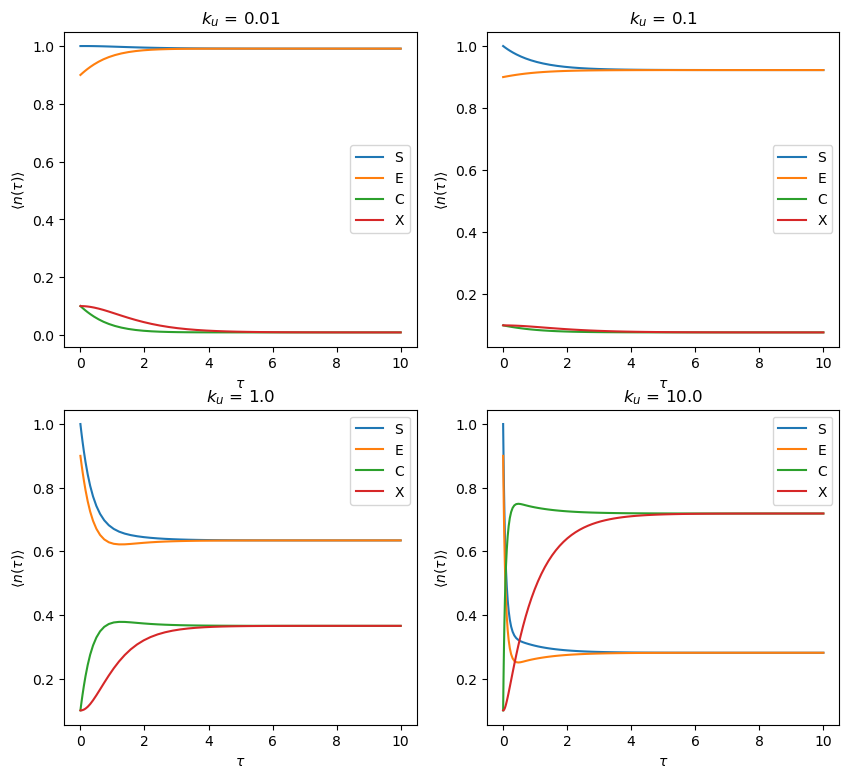

In [35]:
plot_indices = [1,2,3,4]

figure(figsize=(10,9))
for i in range(1,length(plot_indices))
    subplot(2,2,i)
    for j in range(1,length(species(enzyme_system)))
        plot(SOL_mak[plot_indices[i]].t, VAR_mak[plot_indices[i]].μ[j, :], label=alpha_range[plot_indices[i]])
        legend(["S","E","C","X"])
    end
    title(L"$k_u$ = " * string(alpha_range[plot_indices[i]]))
    #yscale("log")
    xlabel(L"$\tau$")
    ylabel(L"$\langle n(\tau)\rangle$")
end

gcf()

In [36]:
savefig("../plots/enzyme/enzyme_mak_means.png")
close("all")

### Plotting the cross variances $\langle \delta n_i(\tau)\delta n_j(\tau) \rangle$:

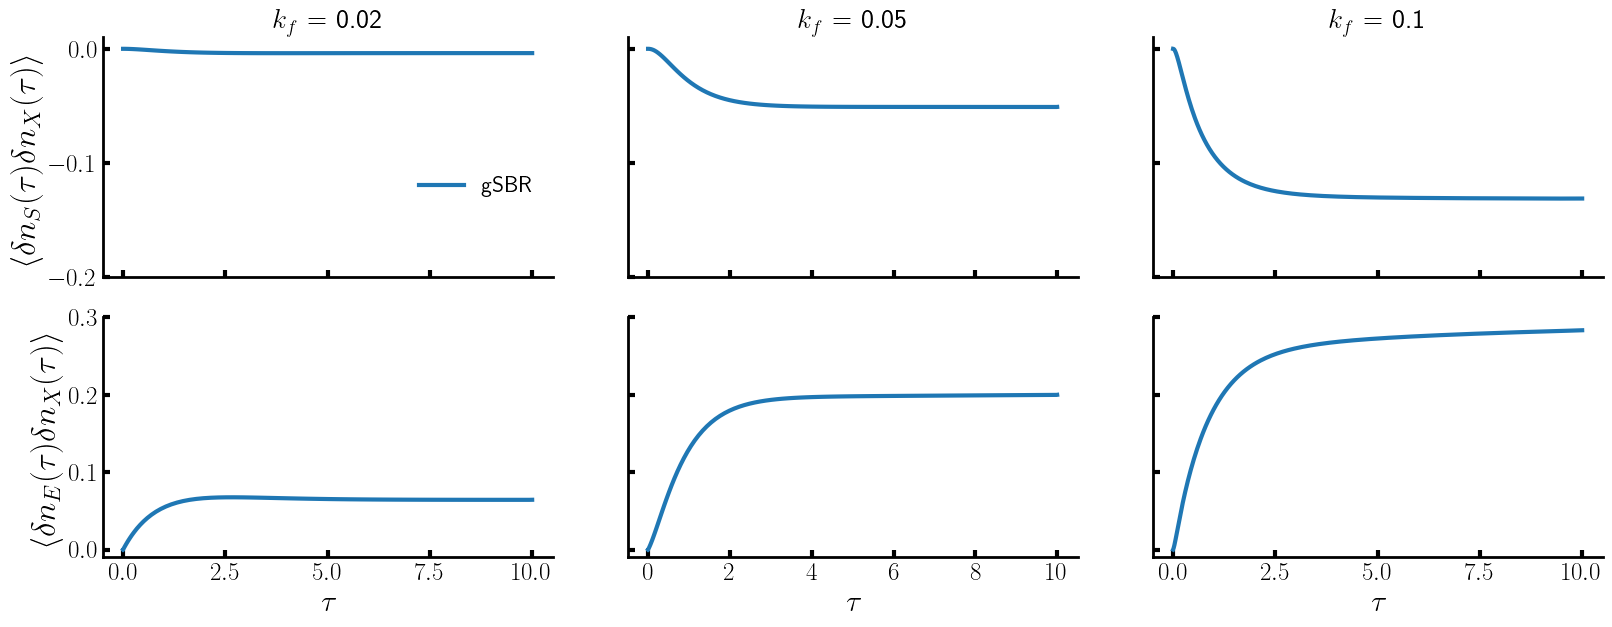

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [ ]:
fig1 = figure(figsize=(15,8))

ax_3 = fig1.add_axes([0.,0, 0.3, 0.3])
ax_4 = fig1.add_axes([0.35,0, 0.3, 0.3])

ax_1 = fig1.add_axes([0.,0.35, 0.3, 0.3])
ax_2 = fig1.add_axes([0.35,0.35, 0.3, 0.3])

ax_5 = fig1.add_axes([0.7,0.35, 0.3, 0.3])

ax_6 = fig1.add_axes([0.7,0., 0.3, 0.3])

axes = [ax_1, ax_2, ax_5, ax_3, ax_4, ax_6]
sat = [2, 3, 4]
skip = 1
cOL = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i in 1:length(sat)
    
    axes[i].plot(SOL[sat[i]].t[1:skip:end], diag(VAR[sat[i]].N[1,4,1:skip:end,1:skip:end]), linestyle="-", c=cOL[1], alpha=1., linewidth=3)

    axes[i].spines["right"].set_visible(false)
    axes[i].spines["top"].set_visible(false)
    axes[i].set_ylim((-0.2, 0.01))
    axes[i].set(xticklabels=[])
    if i != 1
        axes[i].set(yticklabels=[])
    end
    axes[i].set_title("\$k_f\$ = " * string(round(alpha_range[sat[i]], digits=2)), fontsize=20)
end

axes[1].set_ylabel(L"\langle \delta n_S(\tau)\delta n_X(\tau) \rangle", fontsize=24)

for i in 1:length(sat)
    axes[i+3].plot(SOL[sat[i]].t[1:skip:end], diag(VAR[sat[i]].N[2,4,1:skip:end,1:skip:end]), linestyle="-", c=cOL[1], alpha=1., linewidth=3)

    axes[i+3].spines["right"].set_visible(false)
    axes[i+3].spines["top"].set_visible(false)
    axes[i+3].set_xlabel(L"\tau", fontsize=22)
    axes[i+3].set_ylim((-0.01, 0.3))
    if i != 1
        axes[i+3].set(yticklabels=[])
    end
end

axes[4].set_ylabel(L"\langle \delta n_{E}(\tau)\delta n_X(\tau) \rangle", fontsize=24)

ax_1.legend(["gSBR"], bbox_to_anchor=(1., 0.5), loc=1, frameon=false, fontsize=16, ncol=1)

gcf()


In [68]:
savefig("../plots/enzyme/enzyme_gSBR_cross_var.png", bbox_inches="tight")
close("all")

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


### Plotting the two-time correlator $\langle \delta n_X(\tau) \delta n_X(\tau^\prime) \rangle$ :

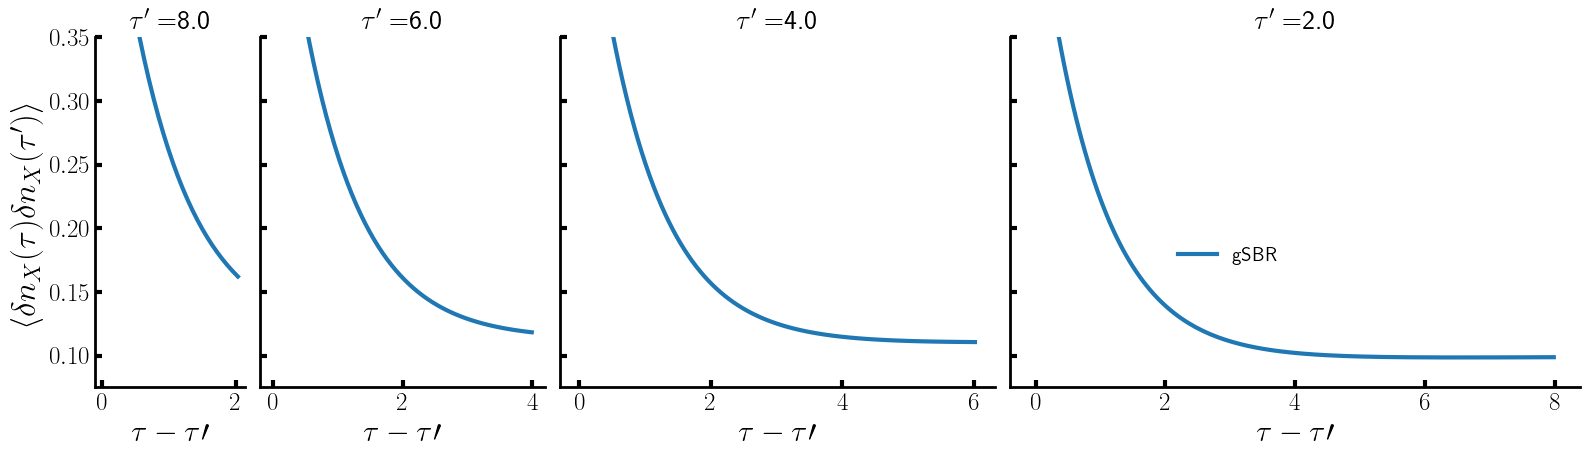

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [ ]:
sat = 4

time_grid_gSBR = SOL[sat].t
plotting_tau =  [2., 4., 6., 8.]

function find_closed_timegrid_indices(timegrid, times)
    return [findmin(abs.(timegrid .- X))[2] for X in times]
end

tau_SBR = find_closed_timegrid_indices(time_grid_gSBR, plotting_tau)

fig = figure(figsize=(15, 3.5))
ax1 = fig.add_axes([0, 0., 0.1, 1])
ax2 = fig.add_axes([0.11, 0., 0.19, 1])
ax3 = fig.add_axes([0.31, 0., 0.29, 1])
ax4 = fig.add_axes([0.61, 0., 0.38, 1])

axis = [ax4, ax3, ax2, ax1]

for j in 1:length(tau_SBR)

    axis[j].plot(time_grid_gSBR[tau_SBR[j]:end] .- time_grid_gSBR[tau_SBR[j]], VAR[sat].N[4, 4, tau_SBR[j]:end, tau_SBR[j]], "-", alpha=1.,linewidth=3)
    
    axis[j].set_title(L"\tau^\prime = " * string(plotting_tau[j]))
    axis[j].spines["right"].set_visible(false)
    axis[j].spines["top"].set_visible(false)
    axis[j].set_xlabel(L"\tau-\tau\prime", fontsize=22)
    axis[j].set_ylim((0.075, 0.35))
end

ax1.set_ylabel(L"\langle \delta n_X(\tau) \delta n_X(\tau^\prime) \rangle ", fontsize=24)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])
ax4.set(yticklabels=[])

ax4.legend(["gSBR"], bbox_to_anchor=(0.5, 0.45), loc=0, frameon=false, fontsize=14)

gcf()

In [66]:
savefig("../plots/enzyme/enzyme_gSBR_lag_correlator_X.png", bbox_inches="tight")
close("all")

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


### Plotting the response: $R_{XX}(\tau,\tau')$:

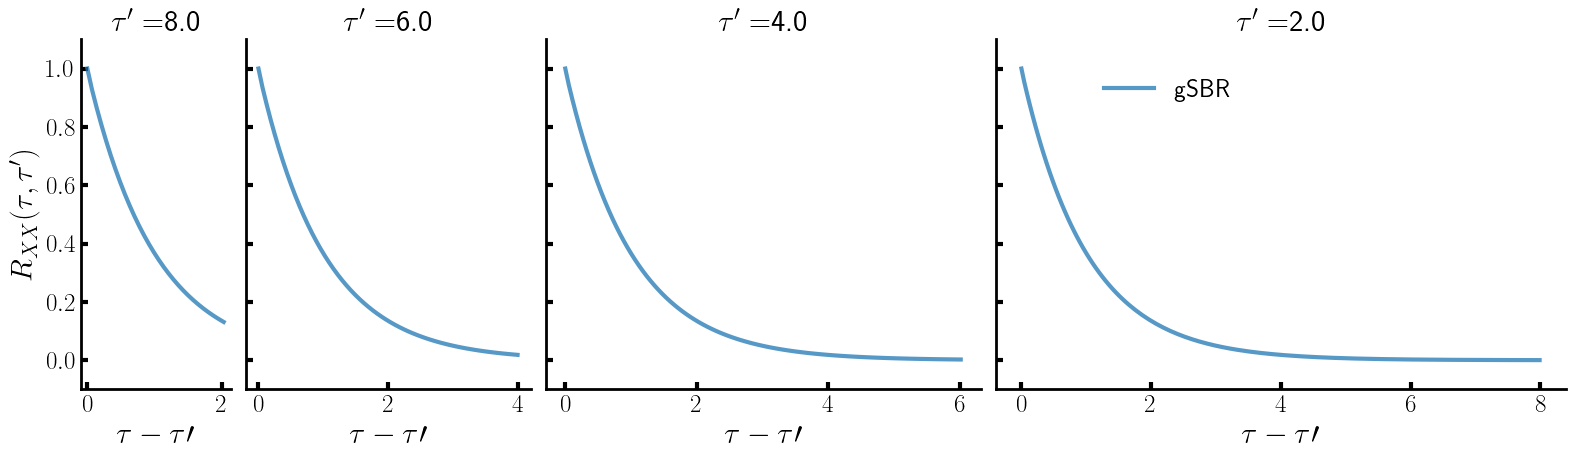

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [69]:
sat = 4

#time_grid_all = EMRE[sat].timeGrid
time_grid_gSBR = SOL[sat].t
plotting_tau =  [2., 4., 6., 8.]

#tau = find_closed_timegrid_indices(time_grid_all, plotting_tau)
tau_SBR = find_closed_timegrid_indices(time_grid_gSBR, plotting_tau)

fig = figure(figsize=(15, 3.5))
ax1 = fig.add_axes([0, 0., 0.1, 1])
ax2 = fig.add_axes([0.11, 0., 0.19, 1])
ax3 = fig.add_axes([0.31, 0., 0.29, 1])
ax4 = fig.add_axes([0.61, 0., 0.38, 1])

axis = [ax4, ax3, ax2, ax1]

for j in 1:length(plotting_tau)

    axis[j].plot(time_grid_gSBR[tau_SBR[j]:end] .- time_grid_gSBR[tau_SBR[j]],(VAR[sat].R[4, 4, tau_SBR[j]:end, tau_SBR[j]]), "-", alpha=0.75,linewidth=3)
    
    axis[j].set_title(L"\tau^\prime = " * string(plotting_tau[j]), fontsize=22)
    axis[j].spines["right"].set_visible(false)
    axis[j].spines["top"].set_visible(false)
    axis[j].set_xlabel(L"\tau-\tau\prime", fontsize=22)
    axis[j].set_ylim((-0.1, 1.1))
end

ax1.set_ylabel(L"R_{XX}(\tau,\tau^\prime)", fontsize=22)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])
ax4.set(yticklabels=[])

ax4.legend(["gSBR"], bbox_to_anchor=(0.45, 0.95), loc=0, frameon=false, fontsize=18)

gcf()

In [70]:
savefig("../plots/enzyme/enzyme_response_gSBR_X.png", bbox_inches="tight")
close("all")

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


## Plotting cross-responses!

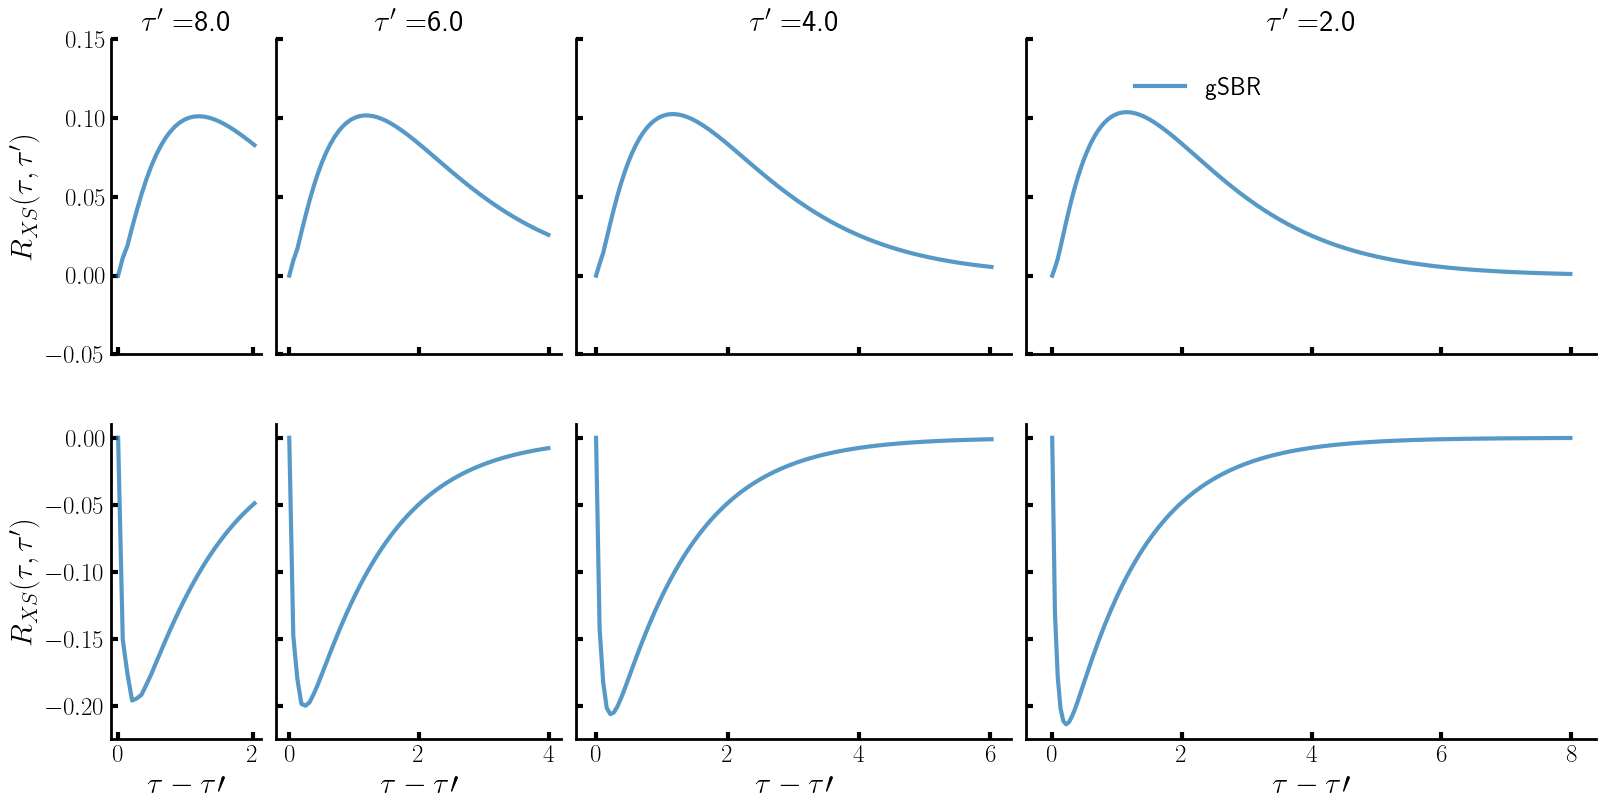

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [ ]:
sat = 4

time_grid_gSBR = SOL[sat].t
plotting_tau =  [2., 4., 6., 8.]

function find_closed_timegrid_indices(timegrid, times)
    return [findmin(abs.(timegrid .- X))[2] for X in times]
end

tau_SBR = find_closed_timegrid_indices(time_grid_gSBR, plotting_tau)

fig = figure(figsize=(15, 7))
ax1 = fig.add_axes([0, 0.55, 0.1, 0.45])
ax2 = fig.add_axes([0.11, 0.55, 0.19, 0.45])
ax3 = fig.add_axes([0.31, 0.55, 0.29, 0.45])
ax4 = fig.add_axes([0.61, 0.55, 0.38, 0.45])

ax11 = fig.add_axes([0, 0., 0.1, 0.45])
ax22 = fig.add_axes([0.11, 0., 0.19, 0.45])
ax33 = fig.add_axes([0.31, 0., 0.29, 0.45])
ax44 = fig.add_axes([0.61, 0., 0.38, 0.45])

axis = [ax4, ax3, ax2, ax1]

axis2 = [ax44, ax33, ax22, ax11]

for j in 1:length(plotting_tau)

    axis[j].plot(time_grid_gSBR[tau_SBR[j]:end] .- time_grid_gSBR[tau_SBR[j]],(VAR[sat].R[4,1, tau_SBR[j]:end, tau_SBR[j]]), "-", alpha=0.75,linewidth=3)
    
    axis[j].set_title(L"\tau^\prime = " * string(plotting_tau[j]), fontsize=22)
    axis[j].spines["right"].set_visible(false)
    axis[j].spines["top"].set_visible(false)
    axis[j].set_ylim((-0.05, 0.15))
end

for j in 1:length(plotting_tau)

    axis2[j].plot(time_grid_gSBR[tau_SBR[j]:end] .- time_grid_gSBR[tau_SBR[j]],(VAR[sat].R[2,1, tau_SBR[j]:end, tau_SBR[j]]), "-", alpha=0.75,linewidth=3)    
    axis2[j].spines["right"].set_visible(false)
    axis2[j].spines["top"].set_visible(false)
    axis2[j].set_xlabel(L"\tau-\tau\prime", fontsize=22)
    axis2[j].set_ylim((-0.225, 0.01))
end

ax1.set_ylabel(L"R_{XS}(\tau,\tau^\prime)", fontsize=22)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])
ax4.set(yticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])

ax4.legend(["gSBR"], bbox_to_anchor=(0.45, 0.95), loc=0, frameon=false, fontsize=18)

ax11.set_ylabel(L"R_{XS}(\tau,\tau^\prime)", fontsize=22)
ax22.set(yticklabels=[])
ax33.set(yticklabels=[])
ax44.set(yticklabels=[])

gcf()


In [74]:
savefig("../plots/enzyme/enzyme_gSBR_cross_response.png", bbox_inches="tight")
close("all")

## Compare with other dynamical methods:

Note that now we use other libraries and code written in python for the implementation of other dynamical methods. They are NOT originally intended to be a part of the package.

In [ ]:
using PyCall
using Pkg
using Conda

py"""
import sys
sys.path.append("../extras/other_dynamics")
"""

@pyimport cheMASTER
@pyimport emre

@pyimport numpy as np
@pyimport importlib

In [ ]:
# Setting up the reactions and the parameters:

num_species     = 4 #Number of species in the reaction system
num_interaction = 3 # Number of interating reactions in the Hamiltonian
num_reactions   = 2*num_species + num_interaction # This counts the total number of possible reactions in the system.
                                        # We have 2N creation and destruction reactions and the rest interaction reactions

# We take the order to be S, E, C, X

# Rate constants for the reaction system: [k1 is Creation and k2 is Destruction]
k1 = np.array([1.,0.,0.,0.]) #len must be equal to num_species
k2 = np.array([1.,0.,0,1.]) #len must be equal to num_species

k3 = np.array([1.,0.1,1.]) 
s_i,r_i = np.zeros([num_interaction,num_species]),np.zeros([num_interaction,num_species])
rxn_par = [k1,k2,k3]

s_i[1,:] = [0,0,1,0] 
r_i[1,:] = [1,1,0,0]
s_i[2,:] = [1,1,0,0]
r_i[2,:] = [0,0,1,0]
s_i[3,:] = [0,1,0,1]
r_i[3,:] = [0,0,1,0]

#The initial concentration of the species. 
#Note: for Gillespie we start each trajectory from a Poisonian random variable with mean as the initial conc.below:
initial_values = np.array([1.,0.9,0.1,0.1])

dt = 0.025
tf = 10.

10.0

In [ ]:
#Run some Gillespie simulations
num_gill = 100
gill     = []

for i in range(1,num_gill)
    push!(gill,cheMASTER.chemical_system_class(num_interaction,num_species,rxn_par,r_i,s_i))
    cheMASTER.gillespie_avg(gill[i],1,initial_values,0,tf,dt,10000)
    print(gill[i])
end

In [60]:
#Plot settings!

cmap = plt.get_cmap("tab10")
col = [cmap(i) for i in np.linspace(0, 1, num_gill-75)]

original_rcParams = copy(plt.rcParams)
rcParams = PyDict(matplotlib["rcParams"])

plot_params = Dict("font.size" => 70, "font.family" => "sans-serif", "text.usetex" => true, "font.weight" => 900, "axes.linewidth" => 2, "xtick.major.width" => 3, "xtick.major.size" => 5, "xtick.minor.width" => 2, "xtick.minor.size" => 3, "ytick.major.width" => 3, "ytick.major.size" => 5, "ytick.minor.width" => 2, "ytick.minor.size" => 3, "axes.labelsize" => 18, "xtick.labelsize" => 18, "ytick.labelsize" => 18)
plot_params2 = (Dict(
    "text.usetex" => false,
    "xtick.labelsize" => 20,
    "ytick.labelsize" => 20,
    "xtick.major.width" => 3,
    "ytick.major.width" => 3,
    "xtick.major.size" => 10,
    "ytick.major.size" => 10,
    "xtick.direction" => "in",
    "ytick.direction" => "in",
    "font.size" => 30,
    "figure.autolayout" => true,
    "figure.figsize" => (10, 5),
    "axes.titlesize" => 20,
    "axes.labelsize" => 20,
    "lines.linewidth" => 3,
    "lines.markersize" => 3,
    "legend.fontsize" => 13,
    "mathtext.fontset" => "stix",
    "axes.linewidth" => 3
))

merge!(rcParams,plot_params)
merge!(rcParams,plot_params2)

PyDict{PyAny, PyAny, true} with 322 entries:
  "webagg.port"            => 8988
  "webagg.address"         => "127.0.0.1"
  "webagg.port_retries"    => 50
  "webagg.open_in_browser" => true
  "backend_fallback"       => false
  "interactive"            => false
  "figure.hooks"           => Any[]
  "toolbar"                => "toolbar2"
  "timezone"               => "UTC"
  "lines.linewidth"        => 3.0
  "lines.linestyle"        => "-"
  "lines.color"            => "C0"
  "lines.marker"           => "None"
  "lines.markerfacecolor"  => "auto"
  "lines.markeredgecolor"  => "auto"
  "lines.markeredgewidth"  => 1.0
  "lines.markersize"       => 3.0
  "lines.dash_joinstyle"   => "round"
  "lines.dash_capstyle"    => "butt"
  ⋮                        => ⋮

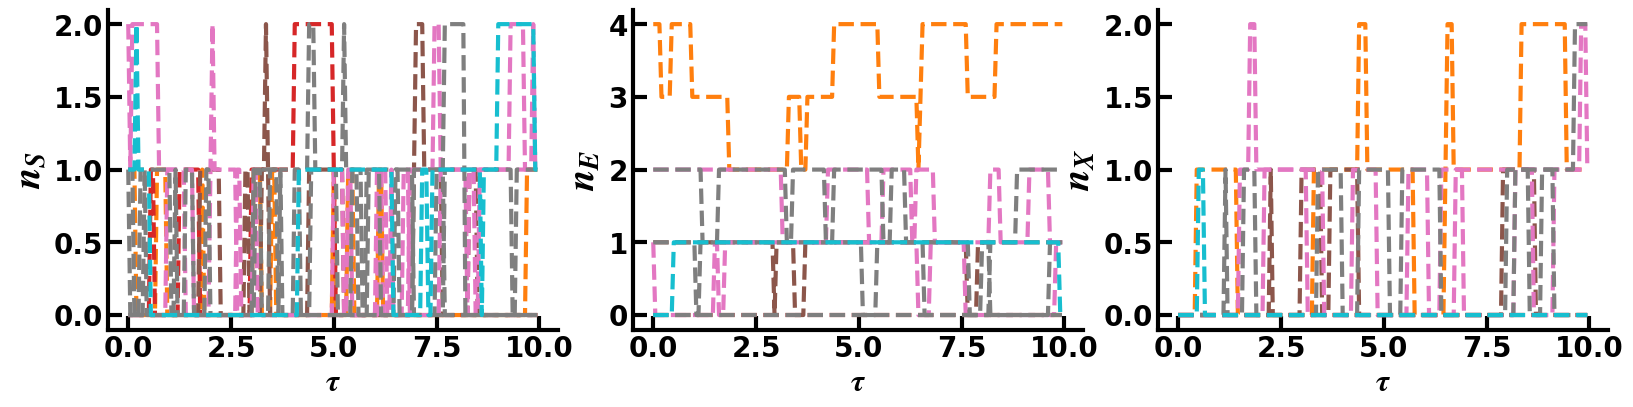

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [ ]:
fig1  = plt.figure(figsize=(15,8))

ax_1 = fig1.add_axes([0.,0.525, 0.3, 0.4])
ax_2 = fig1.add_axes([0.35,0.525, 0.3, 0.4])
ax_3 = fig1.add_axes([0.7,0.525, 0.3, 0.4])
ax_0 = 0
axes = [ax_1,ax_2,ax_0,ax_3]
sat  = [0,3,6]
skip = 2
cOL = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i in range(1,num_species)
    if i != 3
        for j in range(1,num_gill-75)
            if all(gill[j].y[1,:] .- 3 .< 0.)
                axes[i].plot(gill[j].timeGrid[1:skip:end], gill[j].y[i,1:skip:end], "--", c=col[j], alpha=1., linewidth=3)
            end
        end
        axes[i].spines["right"].set_visible(false)
        axes[i].spines["top"].set_visible(false)
        axes[i].set_xlabel(L"${\tau}$",fontsize=22)
    end
end
axes[1].set_ylabel(L"$n_S$",fontsize=28)
axes[2].set_ylabel(L"$n_{E}$",fontsize=28)
axes[4].set_ylabel(L"$n_X$",fontsize=28)

gcf()

In [66]:
plt.savefig("../plots/enzyme/enzyme_gillespie_new.png",bbox_inches="tight")
plt.close("all")

## Run Master equation and EMRE solutions:

In [8]:
alpha_range = exp10.(range(-2, stop=1, length=10))
alpha_range

10-element Vector{Float64}:
  0.01
  0.021544346900318832
  0.046415888336127795
  0.1
  0.2154434690031884
  0.4641588833612779
  1.0
  2.154434690031884
  4.641588833612778
 10.0

In [ ]:
Master = []

for i in range(1,length(alpha_range))

    rxn_par[3][1] = alpha_range[i]
    
    push!(Master,cheMASTER.chemical_system_class(num_interaction,num_species,rxn_par,r_i,s_i))
    print("ex ",i,"\n")
    cheMASTER.initialize_dynamics(Master[i],initial_values,0,tf,dt)
    print("ex ",i,"\n")
    cheMASTER.runDynamics(Master[i],max_num=[6,6,5,5],method = "Eigenvalue",crossCorrelator_tau="connected",variance=true)
    #Why is this executing sooo slowly?
    print(i,"\n")
    
end

In [27]:
# open("../data/enzyme1/master.jls", "w") do f
#     serialize(f, Master)
# end

In [ ]:
# Master = open("../data/enzyme1/master.jls", "r") do f
#     deserialize(f)
# end

In [26]:
EMRE   = []

for i in range(1,length(alpha_range))
    
    rxn_par[3][1] = alpha_range[i]
    push!(EMRE,emre.chemical_system_class(num_interaction,num_species,rxn_par,r_i,s_i))
    emre.initialize_dynamics(EMRE[i],initial_values,0,tf,dt,alpha=1.,volume=1.,measureResponse=true,crossCorrelator_tau=true)
    emre.runDynamics(EMRE[i])

    println(i)
end

1


399it [00:00, 815.35it/s]                          


2


399it [00:00, 675.32it/s]                          


3


399it [00:00, 793.17it/s]                          


4


399it [00:00, 823.48it/s]                          


5


399it [00:00, 806.81it/s]                          


6


399it [00:00, 809.04it/s]                          


7


399it [00:00, 820.14it/s]                          


8


399it [00:00, 668.91it/s]                          


9


399it [00:00, 407.25it/s]                         


10


399it [00:00, 495.87it/s]                          


In [ ]:
# open("../data/enzyme/emre.jls", "w") do f
#     serialize(f, EMRE)
# end

In [ ]:
# EMRE = open("../data/enzyme1/emre.jls", "r") do f
#     deserialize(f)
# end

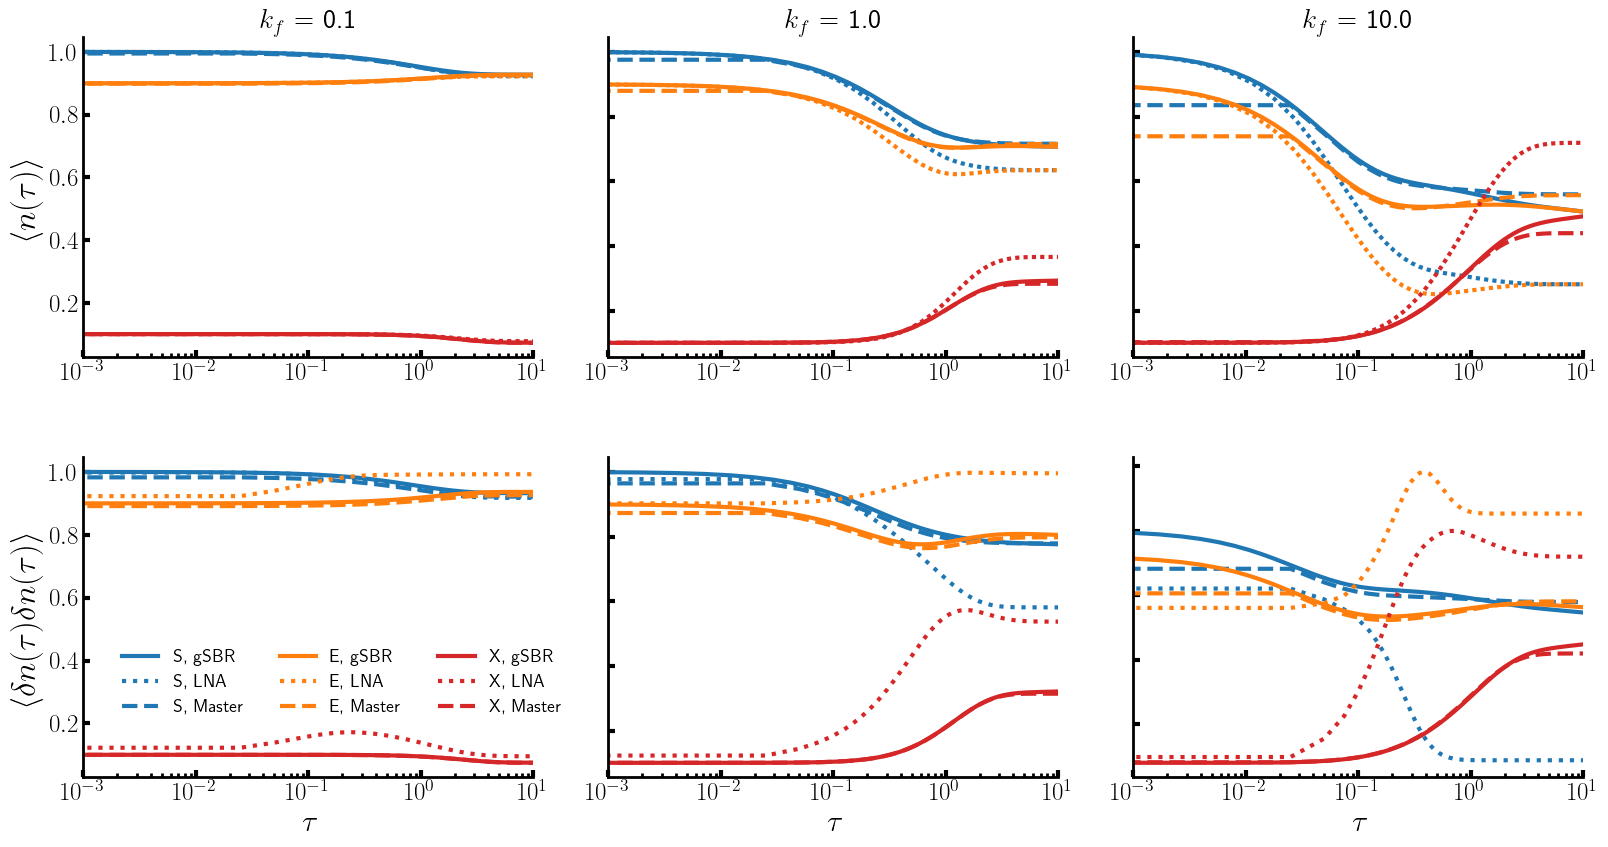

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [ ]:
plot_params3 = (Dict(
    "font.size" => 20,
    "font.family" => "sans-serif",
    "text.usetex" => true,
    "font.weight" => 900,
    "axes.linewidth" => 2,
    "xtick.major.width" => 3,
    "xtick.major.size" => 5,
    "xtick.minor.width" => 2,
    "xtick.minor.size" => 3,
    "ytick.major.width" => 3,
    "ytick.major.size" => 5,
    "ytick.minor.width" => 2,
    "ytick.minor.size" => 3,
    "axes.labelsize" => 18,
    "xtick.labelsize" => 18,
    "ytick.labelsize" => 18,
    "font.size" => 20,
))

rcParams = PyDict(matplotlib["rcParams"])
merge!(rcParams, plot_params3)

fig1 = plt.figure(figsize=(15, 8))

ax_3 = fig1.add_axes([0., 0, 0.3, 0.4])
ax_4 = fig1.add_axes([0.35, 0, 0.3, 0.4])

ax_1 = fig1.add_axes([0., 0.525, 0.3, 0.4])
ax_2 = fig1.add_axes([0.35, 0.525, 0.3, 0.4])

ax_5 = fig1.add_axes([0.7, 0.525, 0.3, 0.4])

ax_6 = fig1.add_axes([0.7, 0., 0.3, 0.4])

axes = [ax_1, ax_2, ax_5, ax_3, ax_4, ax_6]

sat_sbr = [2,3,4]

sat = [3, 6, 9] .+ 1

skip = 1
start_time = 1

cOL = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i in 1:length(sat)
    for j in 1:num_species if j != 3
        axes[i].plot(SOL[sat_sbr[i]].t[start_time:end], VAR[sat_sbr[i]].μ[j, start_time:end], linestyle="-", c=cOL[j], alpha=1., linewidth=3)
        axes[i].plot(SOL_mak[sat_sbr[i]].t[start_time:end], VAR_mak[sat_sbr[i]].μ[j, start_time:end], linestyle=(0, (1, 1)), c=cOL[j], alpha=1., linewidth=3)
        axes[i].plot(Master[sat[i]].timeGrid[start_time:skip:end], Master[sat[i]].y[j, start_time:skip:end]', "--", c=cOL[j], alpha=1., linewidth=3)
    end end
    axes[i].spines["right"].set_visible(false)
    axes[i].spines["top"].set_visible(false)
    axes[i].set_title("\$k_f\$ = " * string(round(alpha_range[sat[i]], digits=2)), fontsize=20)
    axes[i].set_xlim((0.001,10))
    axes[i].set(xticklabels=[])
    axes[i].set_xscale("log")
    if i != 1
        axes[i].set(yticklabels=[])
    end
end
axes[1].set_ylabel(L"$ \langle n(\tau) \rangle $", fontsize=24)

start_time_Master = 1
start_time = 1
for i in 1:length(sat)
    for j in 1:num_species if j != 3
        axes[i + 3].plot(SOL[sat_sbr[i]].t[start_time:end], diag(VAR[sat_sbr[i]].N[j, j, start_time:end, start_time:end]), linestyle="-", c=cOL[j], alpha=1., linewidth=3)
        axes[i + 3].plot(EMRE[sat[i]].timeGrid[start_time_Master:skip:end], EMRE[sat[i]].lna_var[j, j, start_time_Master:skip:end]', linestyle="dotted", c=cOL[j], alpha=1., linewidth=3)
        axes[i + 3].plot(Master[sat[i]].timeGrid[start_time_Master:skip:end], Master[sat[i]].variance[j, start_time_Master:skip:end]', "--", c=cOL[j], alpha=1., linewidth=3)
    end end
    axes[i + 3].spines["right"].set_visible(false)
    axes[i + 3].spines["top"].set_visible(false)
    axes[i + 3].set_xlim((0.001,10))
    axes[i + 3].set_xlabel(L"$ \tau $", fontsize=22)
    axes[i + 3].set_xscale("log")
    if i != 1
        axes[i + 3].set(yticklabels=[])
    end
end
axes[4].set_ylabel(L"$\langle \delta n(\tau)\delta n(\tau) \rangle $", fontsize=24)

axes[4].legend(["S, gSBR","S, LNA","S, Master","E, gSBR","E, LNA","E, Master","X, gSBR","X, LNA","X, Master"],bbox_to_anchor=(1.1, 0.45), loc=1, frameon=false, fontsize=13,ncol=3)

gcf()


In [120]:
plt.savefig("../plots/enzyme/enzyme_means_variance_comparisons_log_time-3.png", bbox_inches="tight")
plt.close("all")


In [63]:
function find_closed_timegrid_indices(timegrid, times)
    return [findmin(abs.(timegrid .- X))[2] for X in times]
end

find_closed_timegrid_indices (generic function with 1 method)

In [ ]:
# plt.savefig("../plots/enzyme/enzyme_num_corr_X.png", bbox_inches="tight")
# plt.close()

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


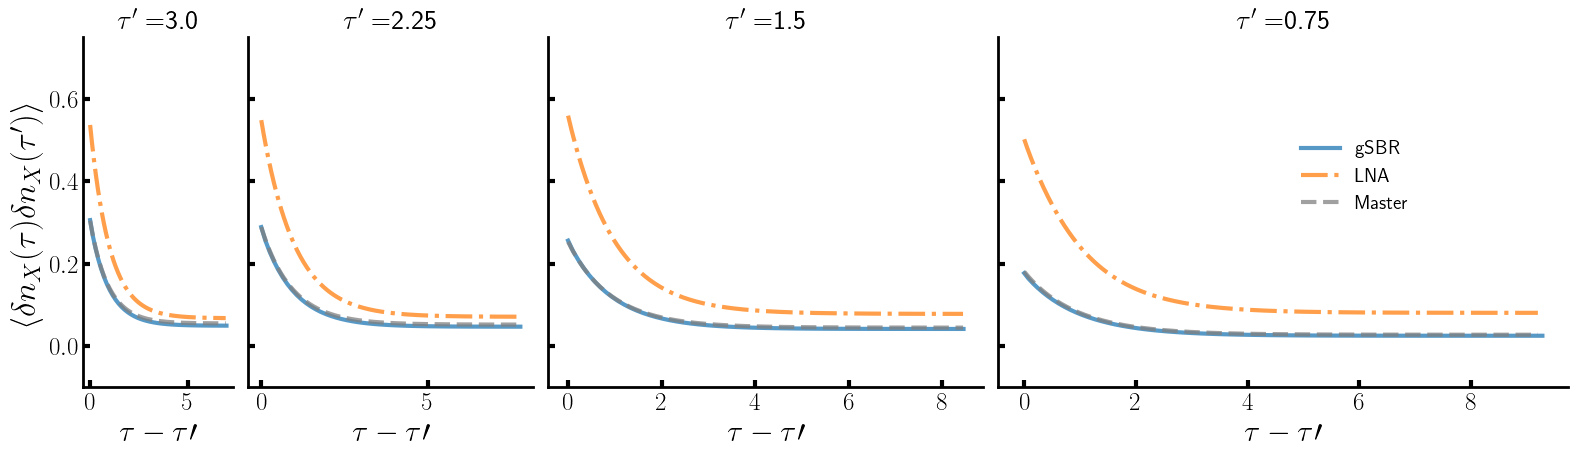

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [81]:
sat_sbr = 3
sat = 7

time_grid_all = EMRE[sat].timeGrid
time_grid_gSBR = SOL[sat_sbr].t
plotting_tau =  [0.75, 1.5, 2.25, 3.0]

tau = find_closed_timegrid_indices(time_grid_all, plotting_tau)
tau_SBR = find_closed_timegrid_indices(time_grid_gSBR, plotting_tau)

fig = figure(figsize=(15, 3.5))
ax1 = fig.add_axes([0, 0., 0.1, 1])
ax2 = fig.add_axes([0.11, 0., 0.19, 1])
ax3 = fig.add_axes([0.31, 0., 0.29, 1])
ax4 = fig.add_axes([0.61, 0., 0.38, 1])

axis = [ax4, ax3, ax2, ax1]

for j in 1:length(tau)
    
    axis[j].plot(time_grid_gSBR[tau_SBR[j]:end] .- time_grid_gSBR[tau_SBR[j]], VAR[sat_sbr].N[4, 4, tau_SBR[j]:end, tau_SBR[j]] , "-", alpha=0.75,linewidth=3)
    
    axis[j].plot(time_grid_all[1:end-tau[j]], EMRE[sat].corr[4, 4, tau[j]+1:end, tau[j]], linestyle="dashdot", alpha=0.75,linewidth=3)

    axis[j].plot(Master[sat].timeGrid[1:end-tau[j]], Master[sat].correlator_tau[4, 4, 1:end-tau[j], tau[j]], "--", alpha=0.75, color="gray",linewidth=3)

    axis[j].set_title(L"\tau^\prime = " * string(plotting_tau[j]))
    axis[j].spines["right"].set_visible(false)
    axis[j].spines["top"].set_visible(false)
    axis[j].set_xlabel(L"\tau-\tau\prime", fontsize=22)
    axis[j].set_ylim((-0.1, 0.75))
end

ax1.set_ylabel(L"\langle \delta n_X(\tau) \delta n_X(\tau^\prime) \rangle ", fontsize=24)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])
ax4.set(yticklabels=[])

ax4.legend(["gSBR", "LNA", "Master"], bbox_to_anchor=(0.5, 0.45), loc=0, frameon=false, fontsize=14)

gcf()

In [ ]:
# plt.savefig("../plots/enzyme/enzyme_num_corr_X_kf1.png", bbox_inches="tight")
# plt.close()

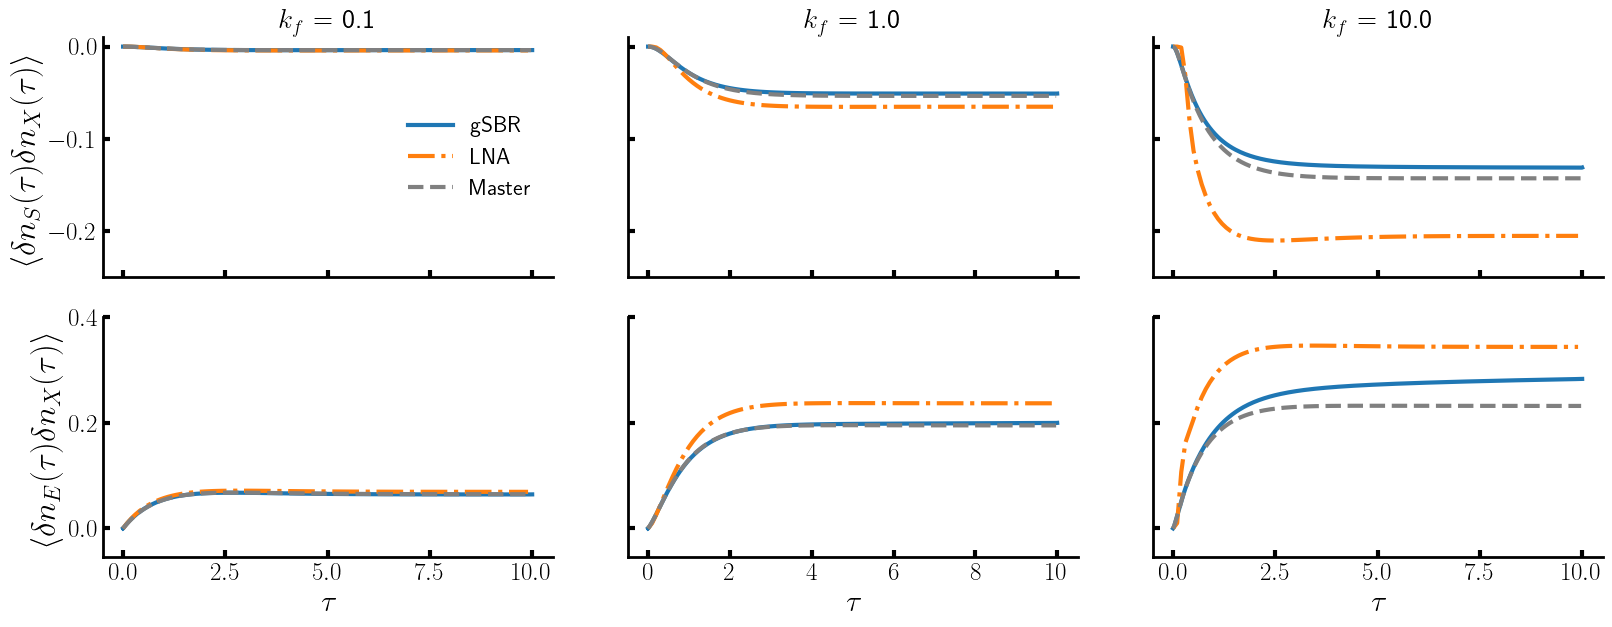

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [ ]:
fig1 = figure(figsize=(15,8))

ax_3 = fig1.add_axes([0.,0, 0.3, 0.3])
ax_4 = fig1.add_axes([0.35,0, 0.3, 0.3])
ax_1 = fig1.add_axes([0.,0.35, 0.3, 0.3])
ax_2 = fig1.add_axes([0.35,0.35, 0.3, 0.3])
ax_5 = fig1.add_axes([0.7,0.35, 0.3, 0.3])
ax_6 = fig1.add_axes([0.7,0., 0.3, 0.3])


axes = [ax_1, ax_2, ax_5, ax_3, ax_4, ax_6]
sat = [3, 6, 9] .+ 1
sat_sbr = [2, 3, 4]
skip = 1
cOL = plt.rcParams["axes.prop_cycle"].by_key()["color"]

for i in 1:length(sat)
    
    axes[i].plot(SOL[sat_sbr[i]].t[1:skip:end], diag(VAR[sat_sbr[i]].N[1,4,1:skip:end,1:skip:end]), linestyle="-", c=cOL[1], alpha=1., linewidth=3)
    axes[i].plot(EMRE[sat[i]].timeGrid[1:skip:end], EMRE[sat[i]].lna_var[1,4,1:skip:end], linestyle="dashdot", c=cOL[2], alpha=1., linewidth=3)
    axes[i].plot(Master[sat[i]].timeGrid[1:end], Master[sat[i]].correlator_tau[1,4,1,1:end], "--", c="gray", alpha=1., linewidth=3)

    axes[i].spines["right"].set_visible(false)
    axes[i].spines["top"].set_visible(false)
    axes[i].set_ylim((-0.25, 0.01))
    axes[i].set(xticklabels=[])
    if i != 1
        axes[i].set(yticklabels=[])
    end
    axes[i].set_title("\$k_f\$ = " * string(round(alpha_range[sat[i]], digits=2)), fontsize=20)
end

axes[1].set_ylabel(L"\langle \delta n_S(\tau)\delta n_X(\tau) \rangle", fontsize=24)

for i in 1:length(sat)
    axes[i+3].plot(SOL[sat_sbr[i]].t[1:skip:end], diag(VAR[sat_sbr[i]].N[2,4,1:skip:end,1:skip:end]), linestyle="-", c=cOL[1], alpha=1., linewidth=3)
    axes[i+3].plot(EMRE[sat[i]].timeGrid[1:skip:end], EMRE[sat[i]].lna_var[2,4,1:skip:end], linestyle="dashdot", c=cOL[2], alpha=1., linewidth=3)
    axes[i+3].plot(Master[sat[i]].timeGrid[1:end], Master[sat[i]].correlator_tau[2,4,1,1:end], "--", c="gray", alpha=1., linewidth=3)

    axes[i+3].spines["right"].set_visible(false)
    axes[i+3].spines["top"].set_visible(false)
    axes[i+3].set_xlabel(L"\tau", fontsize=22)
    axes[i+3].set_ylim((-0.055, 0.4))
    if i != 1
        axes[i+3].set(yticklabels=[])
    end
end

axes[4].set_ylabel(L"\langle \delta n_{E}(\tau)\delta n_X(\tau) \rangle", fontsize=24)

ax_1.legend(["gSBR", "LNA", "Master"], bbox_to_anchor=(1., 0.75), loc=1, frameon=false, fontsize=16, ncol=1)

gcf()


In [ ]:
# plt.savefig("../plots/enzyme/enzyme_equal_time_corr.png", bbox_inches="tight")
# plt.close()

In [ ]:
#Computation intensive and hence we do it for one value of alpha only!

i = 7

rxn_par[3][3] = alpha_range[i]
rxn_par[1]    = rxn_par[1] .+ 0.001

Master_response = cheMASTER.chemical_system_class(num_interaction,num_species,rxn_par,r_i,s_i)
print("Successfully set up the system\n")
cheMASTER.initialize_dynamics(Master_response,initial_values,0,tf,0.25*dt)
print("Successfully initialized the dynamics\n")
cheMASTER.runDynamics(Master_response,max_num=[6,6,5,5],method = "Euler",measureResponse="finite-cross",measureResponse_par=[1.1,1])
print("Successfully ran the dynamics\n")

rxn_par[1] = k1

In [ ]:
# open("../data/enzyme/Master_response_kf1_fine_res.jls", "w") do f
#     serialize(f,Master_response)
# end 

334238931

In [ ]:
# Master_response = open("../data/enzyme/Master_response_kf1_fine_res_script.jls", "r") do f
#     deserialize(f)
# end

PyObject <cheMASTER.chemical_system.chemical_system_class object at 0x3aae7bc50>

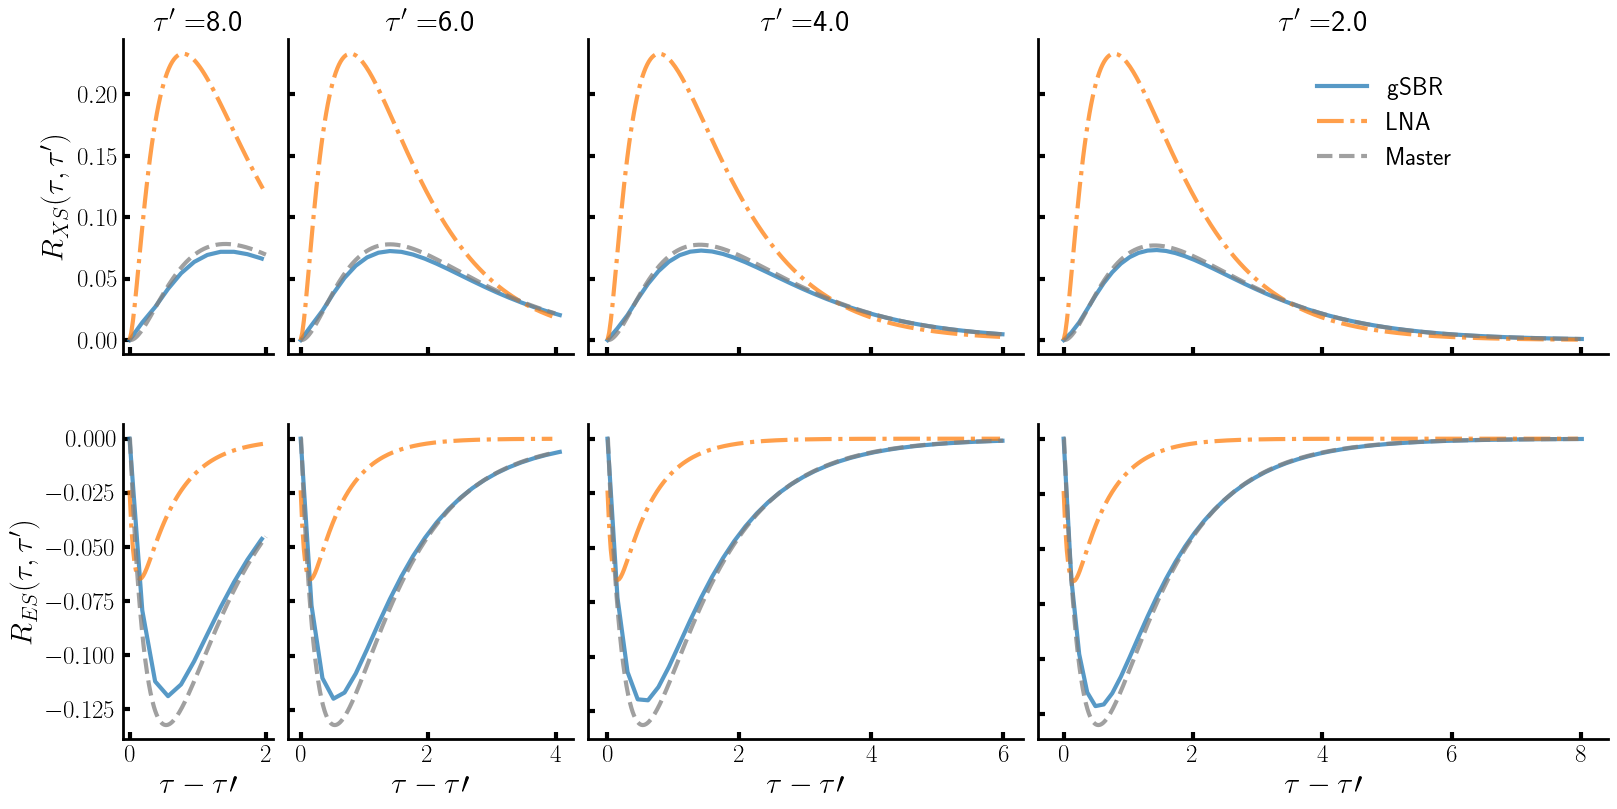

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [ ]:
sat = 7
sat_sbr = 3

time_grid_all = EMRE[sat].timeGrid
time_grid_Master = Master_response.timeGrid
time_grid_gSBR = SOL[sat_sbr].t
plotting_tau =  [2., 4., 6., 8.]

function find_closed_timegrid_indices(timegrid, times)
    return [findmin(abs.(timegrid .- X))[2] for X in times]
end

tau = find_closed_timegrid_indices(time_grid_all, plotting_tau)
tau_SBR = find_closed_timegrid_indices(time_grid_gSBR, plotting_tau)
tau_Master = find_closed_timegrid_indices(time_grid_Master, plotting_tau)

fig = figure(figsize=(15, 7))
ax1 = fig.add_axes([0, 0.55, 0.1, 0.45])
ax2 = fig.add_axes([0.11, 0.55, 0.19, 0.45])
ax3 = fig.add_axes([0.31, 0.55, 0.29, 0.45])
ax4 = fig.add_axes([0.61, 0.55, 0.38, 0.45])

ax11 = fig.add_axes([0, 0., 0.1, 0.45])
ax22 = fig.add_axes([0.11, 0., 0.19, 0.45])
ax33 = fig.add_axes([0.31, 0., 0.29, 0.45])
ax44 = fig.add_axes([0.61, 0., 0.38, 0.45])

axis = [ax4, ax3, ax2, ax1]

axis2 = [ax44, ax33, ax22, ax11]

for j in 1:length(plotting_tau)

    axis[j].plot(time_grid_gSBR[tau_SBR[j]:end] .- time_grid_gSBR[tau_SBR[j]],(VAR[sat_sbr].R[4,1, tau_SBR[j]:end, tau_SBR[j]]), "-", alpha=0.75,linewidth=3)
    axis[j].plot(time_grid_all[1:end-tau[j]], EMRE[sat].resp[4, 1, tau[j]+1:end, tau[j]], linestyle="dashdot", alpha=0.75,linewidth=3)
    axis[j].plot(time_grid_Master[tau_Master[j]:end] .- time_grid_Master[tau_Master[j]], Master_response.Response[4, 1, tau_Master[j]:end, tau_Master[j]], "--", alpha=0.75, color="gray",linewidth=3)
    
    axis[j].set_title(L"\tau^\prime = " * string(plotting_tau[j]), fontsize=22)
    axis[j].spines["right"].set_visible(false)
    axis[j].spines["top"].set_visible(false)
end

for j in 1:length(plotting_tau)

    axis2[j].plot(time_grid_gSBR[tau_SBR[j]:end] .- time_grid_gSBR[tau_SBR[j]],(VAR[sat_sbr].R[2,1, tau_SBR[j]:end, tau_SBR[j]]), "-", alpha=0.75,linewidth=3)
    axis2[j].plot(time_grid_all[1:end-tau[j]], EMRE[sat].resp[2, 1, tau[j]+1:end, tau[j]], linestyle="dashdot", alpha=0.75,linewidth=3)
    axis2[j].plot(time_grid_Master[tau_Master[j]:end] .- time_grid_Master[tau_Master[j]], Master_response.Response[2, 1, tau_Master[j]:end, tau_Master[j]], "--", alpha=0.75, color="gray",linewidth=3)
    axis2[j].spines["right"].set_visible(false)
    axis2[j].spines["top"].set_visible(false)
    axis2[j].set_xlabel(L"\tau-\tau\prime", fontsize=22)
end

ax1.set_ylabel(L"R_{XS}(\tau,\tau^\prime)", fontsize=22)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])
ax4.set(yticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])

ax4.legend(["gSBR", "LNA", "Master"], bbox_to_anchor=(0.45, 0.95), loc=0, frameon=false, fontsize=18)

ax11.set_ylabel(L"R_{ES}(\tau,\tau^\prime)", fontsize=22)
ax22.set(yticklabels=[])
ax33.set(yticklabels=[])
ax44.set(yticklabels=[])

gcf()


In [142]:
plt.savefig("../plots/enzyme/enzyme_response_kf1.png", bbox_inches="tight")
plt.close()

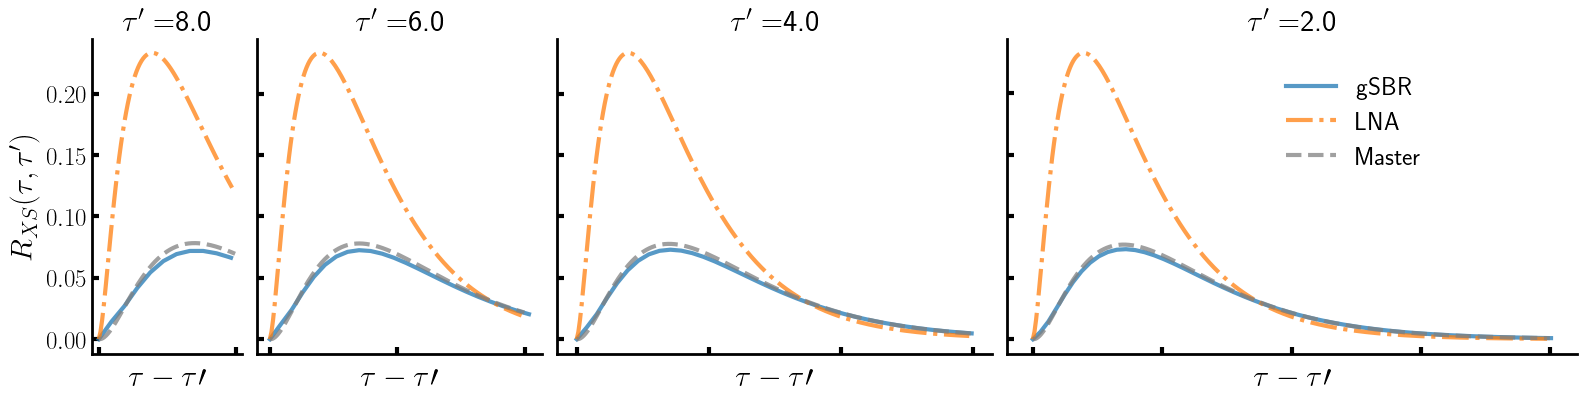

<sys>:0: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [ ]:
sat = 7
sat_sbr = 3

time_grid_all = EMRE[sat].timeGrid
time_grid_Master = Master_response.timeGrid
time_grid_gSBR = SOL[sat_sbr].t
plotting_tau =  [2., 4., 6., 8.]

function find_closed_timegrid_indices(timegrid, times)
    return [findmin(abs.(timegrid .- X))[2] for X in times]
end

tau = find_closed_timegrid_indices(time_grid_all, plotting_tau)
tau_SBR = find_closed_timegrid_indices(time_grid_gSBR, plotting_tau)
tau_Master = find_closed_timegrid_indices(time_grid_Master, plotting_tau)

fig = figure(figsize=(15, 7))
ax1 = fig.add_axes([0, 0.55, 0.1, 0.45])
ax2 = fig.add_axes([0.11, 0.55, 0.19, 0.45])
ax3 = fig.add_axes([0.31, 0.55, 0.29, 0.45])
ax4 = fig.add_axes([0.61, 0.55, 0.38, 0.45])

axis = [ax4, ax3, ax2, ax1]

axis2 = [ax44, ax33, ax22, ax11]

for j in 1:length(plotting_tau)

    axis[j].plot(time_grid_gSBR[tau_SBR[j]:end] .- time_grid_gSBR[tau_SBR[j]],(VAR[sat_sbr].R[4,1, tau_SBR[j]:end, tau_SBR[j]]), "-", alpha=0.75,linewidth=3)
    axis[j].plot(time_grid_all[1:end-tau[j]], EMRE[sat].resp[4, 1, tau[j]+1:end, tau[j]], linestyle="dashdot", alpha=0.75,linewidth=3)
    axis[j].plot(time_grid_Master[tau_Master[j]:end] .- time_grid_Master[tau_Master[j]], Master_response.Response[4, 1, tau_Master[j]:end, tau_Master[j]], "--", alpha=0.75, color="gray",linewidth=3)
    
    axis[j].set_title(L"\tau^\prime = " * string(plotting_tau[j]), fontsize=22)
    axis[j].spines["right"].set_visible(false)
    axis[j].spines["top"].set_visible(false)
    axis[j].set_xlabel(L"\tau-\tau\prime", fontsize=22)
end

ax1.set_ylabel(L"R_{XS}(\tau,\tau^\prime)", fontsize=22)
ax2.set(yticklabels=[])
ax3.set(yticklabels=[])
ax4.set(yticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])

ax4.legend(["gSBR", "LNA", "Master"], bbox_to_anchor=(0.45, 0.95), loc=0, frameon=false, fontsize=18)

gcf()


In [145]:
plt.savefig("../plots/enzyme/enzyme_response_kf1_XS.png", bbox_inches="tight")
plt.close()

### Plotting the time averaged trajectory errors:


In [ ]:
#import Pkg; Pkg.add("Interpolations")
using Interpolations

function time_averaged_trajectory_error(sys_mean, sys_t, sys_ref_mean, sys_ref_t)
    #Interpolates the timegrid of sys_ref to sys and calculates the error

    interp_ref_mean = interpolate((sys_ref_t,), sys_ref_mean, Gridded(Linear()))

    interp_ref_mean_vals = [interp_ref_mean(sys_t[i]) for i in 1:length(sys_t) if sys_t[i] < maximum(sys_ref_t)]

    error = sum(abs, sys_mean[1:length(interp_ref_mean_vals)] ./ interp_ref_mean_vals .- 1 ) / length(sys_t)
    
    return error

end

In [ ]:
#Create the error plots here!